In [130]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from transformers import AutoTokenizer, DataCollatorWithPadding, Trainer, TrainingArguments, GPT2ForSequenceClassification, EarlyStoppingCallback, GPT2TokenizerFast, GPT2ForTokenClassification, GPT2LMHeadModel
from collections import Counter
from peft import LoraConfig, TaskType, get_peft_model
import torch
import pandas as pd
from datasets import Dataset
import torch
from datasets import Dataset
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np
from transformers import Trainer


# GPT2

In [131]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [132]:
DATA_DIR = 'data'
NER_DIR = 'ner_labels'
DATA_FILE = 'classification_final.csv'
NER_FILE = 'merged.jsonl'

In [133]:
cls_path = os.path.join(DATA_DIR, DATA_FILE)
ner_path = os.path.join(DATA_DIR, NER_DIR, NER_FILE)

In [134]:
df = pd.read_csv(cls_path, usecols=['text', 'label'])
df['label'] = df['label'].apply(lambda x: int(x))
dataset = Dataset.from_pandas(df)

df.head()

,text,label
0,RT @anonymized_account mam sliczne imiona dla ...,0
1,@anonymized_account Powiedz mi czy będzie Ci s...,0
2,asocjacja intymna z księdzem Rydzykiem,0
3,@anonymized_account @anonymized_account Jak bę...,0
4,@anonymized_account @anonymized_account @anony...,0


In [135]:
MODEL_ID = 'sdadas/polish-gpt2-medium'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [136]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

tokenizer.pad_token = tokenizer.eos_token

seq_cls_model = GPT2ForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2, pad_token_id=tokenizer.eos_token_id).to(DEVICE)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [137]:
seq_cls_model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): FastGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=1024, out_features=2, bias=False)
)

In [138]:
test_sample = dataset[0:4]
test_sample

{'text': ['RT @anonymized_account mam sliczne imiona dla swoich dzieci ale nie mam dzieci',
  '@anonymized_account Powiedz mi czy będzie Ci się podobał',
  'asocjacja intymna z księdzem Rydzykiem',
  '@anonymized_account @anonymized_account Jak będziesz chciał fotke czegoś z nowego FMa to daj znać :)'],
 'label': [0, 0, 0, 0]}

In [139]:
test_sample_input = tokenizer(test_sample['text'], padding=True, truncation=True, return_tensors='pt').to(DEVICE)

test_sample_input

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': tensor([[41931, 39046,   302,  3319,   737,    72,    67, 13296,  1063, 15682,
          1011,   265,   297,   779, 22955,   528,  1854,  1214,   478,   304,
          1011,  1214,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2],
        [   36,   302,  3319,   737,    72,    67, 13296,  1063, 15682, 12742,
           385,   477,   626,  2713,   309, 27993,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2],
        [  400,    83,   629,   629, 18843,   314,   268, 38726, 35685,   639,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2],
        [   36,   302,  3319,   737,    72,    67, 13296,  1063, 15682, 39046,
           302,  3319,   737,    72,    67, 13296,  1063, 15682,  2221,  3753,
          1533,  2469, 41175,  3290,   268,  

In [140]:
outputs = seq_cls_model(**test_sample_input).logits

In [141]:
# use softmax to get probabilities of each class
probabilities = torch.nn.functional.softmax(outputs.detach().cpu(), dim=-1)

probabilities

tensor([[0.5998, 0.4002],
        [0.4796, 0.5204],
        [0.6403, 0.3597],
        [0.3514, 0.6486]])

In [163]:
def preprocess_function(examples):
    tokens = tokenizer(examples['text'], padding=True, truncation=True)
    tokens['label'] = examples['label']
    return tokens


In [143]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 504/504 [00:00<00:00, 12494.11 examples/s]


In [144]:
tokenized_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 504
})

In [145]:
train_idx, test_idx = train_test_split(range(len(tokenized_dataset)), test_size=0.2, random_state=42, stratify=tokenized_dataset['label'])

In [146]:
train_dataset = tokenized_dataset.select(train_idx)
test_dataset = tokenized_dataset.select(test_idx)

Counter(train_dataset['label']), Counter(test_dataset['label'])

(Counter({0: 350, 1: 53}), Counter({0: 88, 1: 13}))

In [147]:
train_dataset[0]

{'text': '@anonymized_account Liczę do 5 i kończysz z Rozenek',
 'label': 0,
 'input_ids': [36,
  302,
  3319,
  737,
  72,
  67,
  13296,
  1063,
  15682,
  1975,
  726,
  306,
  933,
  292,
  6749,
  286,
  268,
  40561,
  1173,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [148]:
def compute_metrics(pred):
    # roc_auc_score expects binary labels, not one-hot encoded
    predictions, labels = pred

    probs = torch.nn.functional.softmax(torch.tensor(predictions), dim=-1)[:, 1].numpy()

    return {'roc_auc': roc_auc_score(labels, probs)}

In [149]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=8,
    lora_dropout=0.1
)

In [150]:
NUM_EPOCHS = 10
BATCH_SIZE = 32

train_args = TrainingArguments(
    output_dir="gpt2_seq_cls",
    learning_rate=1e-3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [151]:
peft_model = get_peft_model(seq_cls_model, lora_config)

trainer = Trainer(
    model=peft_model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/home/konrad-kielczynski/miniconda3/envs/golem-ner/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [115]:
peft_model.print_trainable_parameters()

trainable params: 12,584,960 || all params: 369,424,384 || trainable%: 3.4066


In [116]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [260]:
trainer.evaluate()

{'eval_loss': 1.2414021492004395,
 'eval_model_preparation_time': 0.01,
 'eval_roc_auc': 0.5716783216783217,
 'eval_runtime': 0.9212,
 'eval_samples_per_second': 109.641,
 'eval_steps_per_second': 4.342}

In [261]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Roc Auc
1,No log,0.326130,0.010000,0.789336
2,No log,0.277524,0.010000,0.893357
3,No log,0.229366,0.010000,0.929196
4,No log,0.200541,0.010000,0.944056
5,No log,0.226968,0.010000,0.943182
6,No log,0.305210,0.010000,0.933566


TrainOutput(global_step=78, training_loss=0.1369351484836676, metrics={'train_runtime': 61.2433, 'train_samples_per_second': 65.803, 'train_steps_per_second': 2.123, 'total_flos': 443149005791232.0, 'train_loss': 0.1369351484836676, 'epoch': 6.0})

In [263]:
texts = test_dataset['text']
labels = test_dataset['label']

In [264]:
def get_cls_embeddings(texts, model, tokenizer):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    pred = outputs.logits
    probs = torch.nn.functional.softmax(pred, dim=-1)[:, 1].cpu().numpy()
    
    return outputs.hidden_states[-1][:, -1, :].cpu().numpy(), probs


embeddings, probs = get_cls_embeddings(texts, peft_model, tokenizer)

In [265]:
probs

array([9.98450160e-01, 4.77326939e-05, 4.11373889e-03, 9.56191182e-01,
       1.68194417e-02, 9.35050310e-04, 3.68804872e-01, 8.76267031e-02,
       1.12349171e-05, 3.04704536e-05, 1.79297029e-04, 1.31602166e-04,
       1.40827685e-03, 1.60321997e-05, 9.85419774e-06, 1.49419069e-01,
       3.03042441e-04, 8.24288558e-03, 7.28567029e-05, 1.11754067e-04,
       1.07783563e-01, 2.72545858e-05, 2.39312591e-04, 4.02011126e-02,
       1.09394919e-03, 7.74228101e-06, 8.33480537e-01, 9.29834903e-04,
       5.31798229e-04, 1.61061165e-04, 2.45347768e-01, 2.15971295e-06,
       3.29943646e-06, 6.11599884e-04, 2.76731998e-01, 9.96760666e-01,
       7.03987572e-03, 2.04792785e-04, 4.75293064e-06, 5.27254522e-01,
       1.04243460e-03, 4.19894494e-02, 4.26890282e-03, 1.17632002e-02,
       9.08431903e-05, 1.32066442e-03, 1.02991282e-04, 7.07084592e-03,
       2.51694070e-03, 8.30039289e-03, 1.22533829e-05, 4.84261138e-04,
       2.49214409e-05, 4.32783272e-05, 1.00763580e-04, 3.11261509e-03,
      

In [266]:
embeddings.shape

(101, 1024)

In [292]:
tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)

test_ebds_2d = tsne.fit_transform(embeddings)

/home/konrad-kielczynski/miniconda3/envs/golem-ner/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [293]:
df = pd.DataFrame({
    'x': test_ebds_2d[:, 0],
    'y': test_ebds_2d[:, 1],
    'label': labels,
})



In [294]:
# optimize th for f1 score

from sklearn.metrics import f1_score

th_values = np.linspace(0, 1, 100)
f1_scores = []

for th in th_values:
    preds = (probs > th).astype(int)
    f1_scores.append(f1_score(labels, preds))

best_th = th_values[np.argmax(f1_scores)]
best_th

0.37373737373737376

In [295]:
from sklearn.metrics import classification_report

auc = roc_auc_score(labels, probs)
print(f'AUC: {auc}')

th = 0.37 # maximize f1-score

pred = (probs > th).astype(int)

print(classification_report(labels, pred))

AUC: 0.944055944055944
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        88
           1       0.77      0.77      0.77        13

    accuracy                           0.94       101
   macro avg       0.87      0.87      0.87       101
weighted avg       0.94      0.94      0.94       101



In [296]:
wrong_preds = np.where(labels != pred)[0]

print(f"Number of wrong predictions: {len(wrong_preds)}")

for idx in wrong_preds:
    print(f"Text: {texts[idx]}")
    print(f"True Label: {labels[idx]}")
    print(f"Predicted Label: {pred[idx]}")
    print()

Number of wrong predictions: 6
Text: RT @anonymized_account Wiem co mogłoby \"uratować\" posła Piętę... niech ogłosi, że wszystko to nieprawda, bo jest....gejem 🤪
True Label: 1
Predicted Label: 0

Text: @anonymized_account @anonymized_account @anonymized_account Kłamstwo kłamstwem pogania. Nic innego tylko łgarstwa i ciągle łamanie prawa.
True Label: 0
Predicted Label: 1

Text: @anonymized_account No cóż agniesz ileś tam oblała krótki test na inteligencję😁😁😁😁
True Label: 1
Predicted Label: 0

Text: @anonymized_account @anonymized_account @anonymized_account @anonymized_account @anonymized_account @anonymized_account nie ma Wisły w futsalu to nie ma.Po chuj drążyć temat ?
True Label: 1
Predicted Label: 0

Text: @anonymized_account @anonymized_account @anonymized_account Szczury, gady, plazy teraz na szczycie ale ewolucja jest nieublagana
True Label: 0
Predicted Label: 1

Text: @anonymized_account jaja i tak już są.Powinni ich wypierdolić dyscyplinarnie jak to mawiał Tomaszewski.
True La

In [297]:
fig = px.scatter(
    df,
    x='x',
    y='y',
    color='label',
    title='t-SNE Visualization of Test Examples',
    hover_data={'text': texts, 
                'prediction': pred},
)

# Show the plot
fig.show()

# gpt 2 augumentation

In [153]:
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_ID, pad_token=tokenizer.eos_token)

token_cls_model = GPT2LMHeadModel.from_pretrained(MODEL_ID, num_labels=5, pad_token_id=tokenizer.eos_token_id).to(DEVICE)

In [154]:
def generation_augmentation(texts, temperature=0.7, top_k=3, top_p=0.8, max_new_tokens=50):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        outputs = token_cls_model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    augmented_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    
    return augmented_texts


texts = [
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
    "W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat",
]


augmented_texts = generation_augmentation(texts)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [155]:
augmented_texts

['W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat liczby osób zatrudnionych w Ministerstwie Sprawiedliwości w latach 2008-2015 oraz w I półroczu 2016 r., a także o podanie informacji o liczbie spraw, w których zapadły wyroki skazujące, a także o liczbie spraw, w których zapadły wyroki uniewinniające. Z poważaniem Poseł',
 'W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat stanu prac nad projektem ustawy o zmianie ustawy o ochronie przyrody, w szczególności w zakresie: - określenia zakresu podmiotowego ustawy, - określenia zakresu podmiotowego ustawy, - określenia zakresu podmiotowego ustawy w kontekście zmian w ustawie o ochronie przyrody, - określenia zakresu podmiot',
 'W związku z powyższym, zwracam się z prośbą o przekazanie mi informacji na temat liczby i wartości umów zawartych przez Ministerstwo Zdrowia z podmiotami leczniczymi na terenie województwa śląskiego, w szczególności w zakresie: 1. Ile umów zostało zawarty

In [156]:
# get all texts with label 1 in train_dataset

train_texts = [train_dataset[i]['text'] for i in range(len(train_dataset)) if train_dataset[i]['label'] == 1]

augmented_texts = generation_augmentation(train_texts, max_new_tokens=20)
augmented_texts


for i in range(5):
    print(f"Original: {train_texts[i]}")
    print(f"Augmented: {augmented_texts[i]}")
    print()

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Original: @anonymized_account A pisdzielstwo, szczury, gady, plazy popromienne, azbestowe?
Augmented: @anonymized_account A pisdzielstwo, szczury, gady, plazy popromienne, azbestowe?A co z tymi, ktorzy sa napromieniowani? A co z tymi, ktorzy sa w

Original: @anonymized_account To nabiję cię w butelkę
Augmented: @anonymized_account To nabiję cię w butelkęA jak nie nabijesz to nie nabijesz. A jak nabijesz to nie nabijesz. A

Original: Wyścig o Plastusiowego Debila trwa.Walka jest zażarta. Walczą: Piasecki, Wielowiejska,Kidawa-Błońska,Król,Czuchnowski. Kto zwycięży?😁😁😁
Augmented: Wyścig o Plastusiowego Debila trwa.Walka jest zażarta. Walczą: Piasecki, Wielowiejska,Kidawa-Błońska,Król,Czuchnowski. Kto zwycięży?😁😁😁😁😁😁😁😁

Original: RT @anonymized_account @anonymized_account Taki sam niemiecki baran ja ty😆😆😆
Augmented: RT @anonymized_account @anonymized_account Taki sam niemiecki baran ja ty😆😆😆Niemiecki baran ja ty😆😆😆�

Original: @anonymized_account @anonymized_account @anonymized_account Sak

In [158]:
df = pd.DataFrame({
    'text': augmented_texts,
    'label': 1
})

df.head()

,text,label
0,"@anonymized_account A pisdzielstwo, szczury, g...",1
1,@anonymized_account To nabiję cię w butelkęA j...,1
2,Wyścig o Plastusiowego Debila trwa.Walka jest ...,1
3,RT @anonymized_account @anonymized_account Tak...,1
4,@anonymized_account @anonymized_account @anony...,1


In [164]:
additional_dataset = Dataset.from_pandas(df)

additional_dataset = additional_dataset.map(preprocess_function, batched=True)

additional_dataset

Map: 100%|██████████| 53/53 [00:00<00:00, 5236.46 examples/s]


Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 53
})

In [165]:
from datasets import concatenate_datasets

# Assuming train_dataset and additional_dataset are of type Dataset
train_dataset = concatenate_datasets([train_dataset, additional_dataset])

In [166]:
train_dataset

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 456
})

In [167]:
seq_cls_model = GPT2ForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2, pad_token_id=tokenizer.eos_token_id).to(DEVICE)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [168]:
peft_model = get_peft_model(seq_cls_model, lora_config)

trainer = Trainer(
    model=peft_model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [169]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,No log,0.253046,0.888986
2,No log,0.165955,0.962413
3,No log,0.225390,0.954545
4,No log,0.311691,0.947552


TrainOutput(global_step=60, training_loss=0.1751444657643636, metrics={'train_runtime': 45.8755, 'train_samples_per_second': 99.399, 'train_steps_per_second': 3.27, 'total_flos': 334286098661376.0, 'train_loss': 0.1751444657643636, 'epoch': 4.0})

In [170]:
trainer.evaluate()

{'eval_loss': 0.16595503687858582,
 'eval_roc_auc': 0.9624125874125875,
 'eval_runtime': 0.9228,
 'eval_samples_per_second': 109.453,
 'eval_steps_per_second': 4.335,
 'epoch': 4.0}

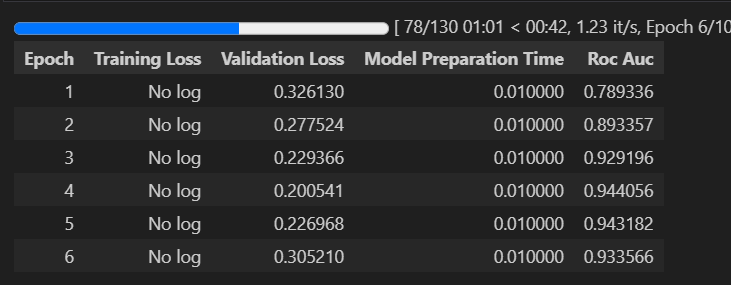

In [171]:
augmented_texts = generation_augmentation(train_texts, temperature=1.5, top_k=10, top_p=0.9, max_new_tokens=20)


df = pd.DataFrame({
    'text': augmented_texts,
    'label': 1
})

additional_dataset = Dataset.from_pandas(df)

additional_dataset = additional_dataset.map(preprocess_function, batched=True)

train_dataset = concatenate_datasets([train_dataset, additional_dataset])

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Map: 100%|██████████| 53/53 [00:00<00:00, 8040.59 examples/s]


In [172]:

peft_model = get_peft_model(seq_cls_model, lora_config)

trainer = Trainer(
    model=peft_model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

In [173]:
trainer.train()

Epoch,Training Loss,Validation Loss,Roc Auc
1,No log,0.297228,0.864510
2,No log,0.186853,0.969406
3,No log,0.209863,0.951923
4,No log,0.427634,0.937063


TrainOutput(global_step=64, training_loss=0.18523350358009338, metrics={'train_runtime': 50.4909, 'train_samples_per_second': 100.81, 'train_steps_per_second': 3.169, 'total_flos': 373139526795264.0, 'train_loss': 0.18523350358009338, 'epoch': 4.0})

In [174]:
trainer.evaluate()

{'eval_loss': 0.18685321509838104,
 'eval_roc_auc': 0.9694055944055944,
 'eval_runtime': 0.9327,
 'eval_samples_per_second': 108.288,
 'eval_steps_per_second': 4.289,
 'epoch': 4.0}

# For token classification

In [7]:
import json
import re

In [8]:
def process_text(text, labels, label_map = {"Podmiot": 1, "Organizacja": 3}):

    #label_map = {"Podmiot": 1, "Organizacja": 2}
    chars_labels = np.zeros((len(text),), dtype=int)
    
    for start, end, label_type in labels:
        chars_labels[start: end] = label_map[label_type]

    words_with_delimiters = re.findall(r'\S+|\s', text)
    # print(f"{len(text) = }, {len(''.join(words_with_delimiters)) = }")
    word_labels = []
    
    current_index = 0
    for word in words_with_delimiters:
        word_len = len(word)

        # print(f"{word = }, {word_len = }")

        if word.strip():  # If the word is not just whitespace
            # Determine the label for this word based on the character labels
            #print(chars_labels[current_index:current_index + word_len])
            word_label = int(np.median(chars_labels[current_index:current_index + word_len]))
        else:
            word_label = 0  # No label for spaces or other delimiters
        
        word_labels.append(word_label)
        current_index += word_len

    empty_indices = [i for i, word in enumerate(words_with_delimiters) if (not word.strip()) or (len(word) == 1)]
    words_with_delimiters = [word for i, word in enumerate(words_with_delimiters) if i not in empty_indices]
    word_labels = [label for i, label in enumerate(word_labels) if i not in empty_indices]

    assert len(words_with_delimiters) == len(word_labels)
    
    return words_with_delimiters, word_labels

In [9]:
output_data = []

with open(ner_path, 'r', encoding='utf-8') as f:
    
    for line in f:
        data = json.loads(line)
        text = data['text']
        labels = data['label']
        
        words, word_labels = process_text(text, labels)
        
        output_data.append({
            'id': data['id'],
            'words': words,
            'labels': word_labels
        })

In [10]:
output_data

[{'id': 752,
  'words': ['RT',
   '@anonymized_account',
   'mam',
   'sliczne',
   'imiona',
   'dla',
   'swoich',
   'dzieci',
   'ale',
   'nie',
   'mam',
   'dzieci'],
  'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 {'id': 753,
  'words': ['@anonymized_account',
   'Powiedz',
   'mi',
   'czy',
   'będzie',
   'Ci',
   'się',
   'podobał'],
  'labels': [0, 0, 0, 0, 0, 0, 0, 0]},
 {'id': 754,
  'words': ['asocjacja', 'intymna', 'księdzem', 'Rydzykiem'],
  'labels': [0, 0, 1, 1]},
 {'id': 755,
  'words': ['@anonymized_account',
   '@anonymized_account',
   'Jak',
   'będziesz',
   'chciał',
   'fotke',
   'czegoś',
   'nowego',
   'FMa',
   'to',
   'daj',
   'znać',
   ':)'],
  'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]},
 {'id': 756,
  'words': ['@anonymized_account',
   '@anonymized_account',
   '@anonymized_account',
   '@anonymized_account',
   'Gdybyśmy',
   'nie',
   'mieli',
   'Guilherme,',
   'to',
   'jak',
   'najbardziej.'],
  'labels': [0, 0, 0, 0, 0, 0, 0,

In [11]:
ENTITY_TYPES = {
    0: 'O',
    1: 'B-Podmiot',
    2: 'I-Podmiot',
    3: 'B-Organizacja',
    4: 'I-Organizacja'
}

In [12]:
tokenizer = GPT2TokenizerFast.from_pretrained(MODEL_ID, add_prefix_space=True)
tokenizer.pad_token = tokenizer.eos_token

token_cls_model = GPT2ForTokenClassification.from_pretrained(MODEL_ID, num_labels=5, pad_token_id=tokenizer.eos_token_id).to(DEVICE)

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at sdadas/polish-gpt2-medium and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
words_list = [data['words'] for data in output_data]
labels_list = [data['labels'] for data in output_data]


words_list[2], labels_list[2]

(['asocjacja', 'intymna', 'księdzem', 'Rydzykiem'], [0, 0, 1, 1])

In [14]:
tokenized_inputs = tokenizer(
    words_list,
    is_split_into_words=True,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

print(tokenized_inputs.word_ids())


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 4, 5, 6, 7, 8, 9, 10, 11, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [15]:
datset = Dataset.from_dict({
    "tokens": words_list,
    "labels": labels_list
})

datset

Dataset({
    features: ['tokens', 'labels'],
    num_rows: 504
})

In [16]:
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples['tokens'], is_split_into_words=True, padding=True, truncation=True, return_tensors="pt")

    
    labels = []
    has_label = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = [-100 if (word_id is None or tokenized_inputs['input_ids'][i][word_id] == tokenizer.pad_token_id) else label[word_id] for word_id in word_ids]
        labels.append(label_ids)

        has_label.append(True if sum(label) > 0 else False)
      

        if i == 2:
            print("Old", examples['tokens'][2])
            print("Word ids", word_ids)
            print("Old", label)
            print("New", label_ids)
            print(len(label_ids))


    tokenized_inputs["labels"] = labels
    tokenized_inputs["has_label"] = has_label
    return tokenized_inputs


tokenized_dataset = datset.map(preprocess_function, batched=True)

Map: 100%|██████████| 504/504 [00:00<00:00, 4269.10 examples/s]

Old ['asocjacja', 'intymna', 'księdzem', 'Rydzykiem']
Word ids [0, 0, 0, 0, 1, 1, 2, 3, 3, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Old [0, 0, 1, 1]
New [0, 0, 0, 0, 0, 0, 1, 1, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

In [17]:
train_idx, test_idx = train_test_split(range(len(tokenized_dataset)), test_size=0.2, random_state=42, stratify=tokenized_dataset['has_label'])

train_dataset = tokenized_dataset.select(train_idx)
test_dataset = tokenized_dataset.select(test_idx)


Counter(train_dataset['has_label']), Counter(test_dataset['has_label'])

(Counter({False: 297, True: 106}), Counter({False: 75, True: 26}))

In [18]:
# remove has_label from dataset
train_dataset = train_dataset.remove_columns(['has_label', 'tokens'])
test_dataset = test_dataset.remove_columns(['has_label', 'tokens'])

In [19]:
from seqeval.metrics import accuracy_score as seq_accuracy
from seqeval.metrics import f1_score as seq_f1

In [20]:
def compute_metrics(eval_pred):

    preds, labels = eval_pred
    preds = preds.argmax(-1)

    true_predictions = [
        [ENTITY_TYPES[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(preds, labels)
    ]

    true_labels = [
        [ENTITY_TYPES[l] for l in label if l != -100]
        for label in labels
    ]

    return {"accuracy": seq_accuracy(true_labels, true_predictions), "f1": seq_f1(true_labels, true_predictions, average='weighted')}

In [32]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

train_args = TrainingArguments(
    output_dir="gpt2_token_cls",
    learning_rate=1e-3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

lora_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    r=64,
    lora_alpha=1,
    lora_dropout=0.1
)

In [33]:
peft_model = get_peft_model(token_cls_model, lora_config)

trainer = Trainer(
    model=peft_model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


In [34]:
trainer.evaluate()

{'eval_loss': 1.8007140159606934,
 'eval_model_preparation_time': 0.0067,
 'eval_accuracy': 0.24435318275154005,
 'eval_f1': 0.024239489542875397,
 'eval_runtime': 0.9267,
 'eval_samples_per_second': 108.99,
 'eval_steps_per_second': 4.316}

In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1
1,No log,0.152015,0.006700,0.965777,0.000000
2,No log,0.101514,0.006700,0.971937,0.482009
3,No log,0.086043,0.006700,0.973990,0.488345
4,No log,0.082141,0.006700,0.975359,0.583881
5,No log,0.077155,0.006700,0.977755,0.598776
6,No log,0.076080,0.006700,0.978097,0.633943
7,No log,0.074461,0.006700,0.979124,0.645951
8,No log,0.072683,0.006700,0.979466,0.653969
9,No log,0.075229,0.006700,0.979124,0.644620
10,No log,0.076982,0.006700,0.978782,0.652923


TrainOutput(global_step=130, training_loss=0.09332312804002028, metrics={'train_runtime': 101.1375, 'train_samples_per_second': 79.693, 'train_steps_per_second': 2.571, 'total_flos': 723839751889800.0, 'train_loss': 0.09332312804002028, 'epoch': 10.0})

In [36]:
trainer.evaluate()

{'eval_loss': 0.07268305867910385,
 'eval_model_preparation_time': 0.0067,
 'eval_accuracy': 0.9794661190965093,
 'eval_f1': 0.6539690071660494,
 'eval_runtime': 0.9231,
 'eval_samples_per_second': 109.414,
 'eval_steps_per_second': 4.333,
 'epoch': 10.0}